# Imports

In [1]:
from pathlib import Path
import numpy as np
from applefy.detections.contrast import Contrast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import pandas as pd

from s4hci.utils.data_handling import load_adi_data
from s4hci.detection_limits.applefy_wrapper import S4DataReduction, cADIDataReduction, PCADataReductionGPU
from applefy.utils import flux_ratio2mag, mag2flux_ratio

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma, LaplaceBootstrapTest

from applefy.utils.positions import center_subpixel

# Files we need

In [2]:
dataset_name = "HD22049_304_199_C-0065_C_"
#dataset_name = "HD22049_310_0100_C-0656_A_"
#dataset_name = "HD22049_351_096_C-0679_A_"

In [3]:
dataset_file = Path("/fast/mbonse/s4/30_data/" + dataset_name + ".hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/06_contrast_curves/02_cc_restored_models")
pre_trained_noise_model = "/fast/mbonse/s4/70_results/06_contrast_curves/01_train_each_model_once/" + dataset_name + "/models/noise_model_fine_tuned.pkl"
pre_trained_normalization = "/fast/mbonse/s4/70_results/06_contrast_curves/01_train_each_model_once/" + dataset_name + "/models/normalization_model.pkl"

# Load the data

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object",
    psf_template_tag="psf_template",
    para_tag="header_object/PARANG")

dit_psf_template = 0.0042560
dit_science = 0.08

science_data = science_data[:, 12:-12, 12:-12]

psf_template = np.median(raw_psf_template_data, axis=0)
psf_template = psf_template - np.min(psf_template)

# Fit the FWHM

In [5]:
from astropy.modeling.functional_models import Moffat2D
from astropy.modeling import fitting

In [6]:
# Fit the data using astropy.modeling
p_init = Moffat2D(amplitude=1e4, x_0=10, y_0=10)
fit_p = fitting.LevMarLSQFitter()

y, x = np.mgrid[:psf_template.shape[0],
                :psf_template.shape[1]]
p = fit_p(p_init, x, y, psf_template)

In [7]:
fwhm = np.round(p.fwhm, 1)
fwhm

3.6

# Create fake planet experiments

In [8]:
tmp_exp_root = experiment_root_dir / dataset_file.name[:-5]
tmp_exp_root.mkdir(exist_ok=True)

In [9]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=1., # A factor to account e.g. for ND filters
    checkpoint_dir=tmp_exp_root)

In [10]:
# fake planet brightness
flux_ratio_mag = 14
flux_ratio = mag2flux_ratio(flux_ratio_mag)

print("Brightness of fake planets in mag: " + str(flux_ratio_mag))
print("Planet-to-star flux ratio: " + str(flux_ratio))

Brightness of fake planets in mag: 14
Planet-to-star flux ratio: 2.5118864315095823e-06


In [11]:
center = center_subpixel(science_data[0])
separations = np.arange(0, center[0], fwhm / 2.)[2:]
separations

array([ 3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. , 19.8, 21.6,
       23.4, 25.2, 27. , 28.8, 30.6, 32.4, 34.2, 36. , 37.8, 39.6, 41.4,
       43.2, 45. , 46.8, 48.6, 50.4, 52.2, 54. , 55.8, 57.6])

In [12]:
num_fake_planets = 6

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratio,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


# Create S4 model

In [13]:
s4_model = S4DataReduction(
    noise_model_file=pre_trained_noise_model,
    normalization_model_file=pre_trained_normalization,
    device = "cpu",
    work_dir = None,
    verbose = True)

In [14]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=s4_model,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:02<00:00, 71.24it/s]

[DONE]


# Create PCA model

In [15]:
pca_model = PCADataReductionGPU(
    approx_svd=10000,
    pca_numbers=np.concatenate(
        [np.arange(1, 100, 2),
         np.arange(100, 505, 5)]),
    device="cpu",
    verbose=False)

In [16]:
old_results = contrast_instance.results_dict
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_model,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [02:44<00:00,  1.13it/s]

[DONE]


In [17]:
contrast_instance.results_dict.update(old_results)

In [27]:
contrast_errors.to_pickle(dataset_file.name[:-5] + "_cc_errors.pkl")

# Create cADI model

In [18]:
cadi_model = cADIDataReduction()

In [19]:
old_results = contrast_instance.results_dict
contrast_instance.run_fake_planet_experiments(
    algorithm_function=cadi_model,
    num_parallel=1)

Running fake planet experiments...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:01<00:00, 146.97it/s]

[DONE]


In [20]:
contrast_instance.results_dict.update(old_results)

In [21]:
contrast_instance.results_dict.keys()

dict_keys(['cADI', 'PCA_001_components', 'PCA_003_components', 'PCA_005_components', 'PCA_007_components', 'PCA_009_components', 'PCA_011_components', 'PCA_013_components', 'PCA_015_components', 'PCA_017_components', 'PCA_019_components', 'PCA_021_components', 'PCA_023_components', 'PCA_025_components', 'PCA_027_components', 'PCA_029_components', 'PCA_031_components', 'PCA_033_components', 'PCA_035_components', 'PCA_037_components', 'PCA_039_components', 'PCA_041_components', 'PCA_043_components', 'PCA_045_components', 'PCA_047_components', 'PCA_049_components', 'PCA_051_components', 'PCA_053_components', 'PCA_055_components', 'PCA_057_components', 'PCA_059_components', 'PCA_061_components', 'PCA_063_components', 'PCA_065_components', 'PCA_067_components', 'PCA_069_components', 'PCA_071_components', 'PCA_073_components', 'PCA_075_components', 'PCA_077_components', 'PCA_079_components', 'PCA_081_components', 'PCA_083_components', 'PCA_085_components', 'PCA_087_components', 'PCA_089_comp

# Compute the contrast curve

In [22]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "AS", # or "AS"
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "AS",
    psf_fwhm_radius=fwhm/2)

In [23]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [24]:
statistical_test = TTest()

In [25]:
contrast_curves, contrast_errors = contrast_instance.compute_analytic_contrast_curves(
    statistical_test=statistical_test,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=20,
    pixel_scale=0.02718)

Computing contrast curve for cADI


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:41<00:00,  1.33s/it]


Computing contrast curve for PCA_001_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:40<00:00,  1.30s/it]


Computing contrast curve for PCA_003_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:39<00:00,  1.28s/it]


Computing contrast curve for PCA_005_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_007_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_009_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_011_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_013_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_015_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_017_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_019_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_021_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_023_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_025_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_027_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:36<00:00,  1.19s/it]


Computing contrast curve for PCA_029_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_031_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_033_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_035_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_037_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_039_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_041_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_043_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_045_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_047_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:36<00:00,  1.19s/it]


Computing contrast curve for PCA_049_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_051_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_053_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_055_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_057_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_059_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_061_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_063_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_065_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_067_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_069_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_071_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_073_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_075_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_077_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_079_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.19s/it]


Computing contrast curve for PCA_081_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_083_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_085_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_087_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_089_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_091_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_093_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_095_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_097_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_099_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_100_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_105_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_110_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_115_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_120_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_125_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_130_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_135_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_140_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.19s/it]


Computing contrast curve for PCA_145_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_150_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_155_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_160_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_165_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_170_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_175_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_180_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_185_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_190_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_195_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_200_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_205_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_210_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_215_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_220_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_225_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_230_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_235_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_240_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_245_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_250_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_255_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_260_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_265_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_270_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_275_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:36<00:00,  1.19s/it]


Computing contrast curve for PCA_280_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_285_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_290_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_295_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_300_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_305_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_310_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_315_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_320_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:40<00:00,  1.31s/it]


Computing contrast curve for PCA_325_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.26s/it]


Computing contrast curve for PCA_330_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_335_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_340_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_345_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_350_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_355_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_360_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_365_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_370_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_375_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_380_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_385_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_390_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.23s/it]


Computing contrast curve for PCA_395_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_400_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:39<00:00,  1.26s/it]


Computing contrast curve for PCA_405_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.23s/it]


Computing contrast curve for PCA_410_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:36<00:00,  1.19s/it]


Computing contrast curve for PCA_415_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_420_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_425_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.25s/it]


Computing contrast curve for PCA_430_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.24s/it]


Computing contrast curve for PCA_435_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_440_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_445_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_450_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.23s/it]


Computing contrast curve for PCA_455_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_460_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_465_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_470_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.22s/it]


Computing contrast curve for PCA_475_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_480_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_485_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_490_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.21s/it]


Computing contrast curve for PCA_495_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for PCA_500_components


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for s4_mean


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.20s/it]


Computing contrast curve for s4_median


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:37<00:00,  1.19s/it]


In [26]:
contrast_curves.to_pickle(dataset_file.name[:-5] + "_cc.pkl")

In [28]:
contrast_errors.to_pickle(dataset_file.name[:-5] + "_cc_errors.pkl")

# Extract the values we are interested in

In [29]:
separations_arcsec = contrast_curves.reset_index(level=0).index
separations_FWHM = contrast_curves.reset_index(level=1).index

In [30]:
cADI_contrast_curve = contrast_curves["cADI"]
cADI_contrast_error = contrast_errors["cADI"]

In [31]:
s4_contrast_curve = contrast_curves["s4_mean"]
s4_contrast_error = contrast_errors["s4_mean"]

In [32]:
pca_contrast_curves = contrast_curves.drop(["cADI", "s4_mean", "s4_median"], axis=1)
pca_contrast_errors = contrast_errors.drop(["cADI", "s4_mean", "s4_median"], axis=1)

In [33]:
# compute the overall best contrast curve
overall_best_pca = np.min(pca_contrast_curves.values, axis=1)

# get the error bars of the the overall best contrast curve
best_idx = np.argmin(pca_contrast_curves.values, axis=1)
best_contrast_errors_pca = pca_contrast_errors.values[np.arange(len(best_idx)), best_idx]

# Load the PCA results (no longer needed)

In [34]:
data = pd.read_csv(dataset_name + ".csv")
pca_sep = data["Default Dataset"][1:].values.astype(float)
pca_contrast = mag2flux_ratio(data["Unnamed: 1"][1:].values.astype(float))

# Plot the Contrast Curves

In [35]:
# Find one color for each number of PCA components used.
colors = sns.dark_palette(
    "Blue",
    n_colors=len(contrast_curves.columns))
colors

[(0.14289171628325356, 0.14289583210240445, 0.19919851992384108),
 (0.14233135661155452, 0.14233545629023817, 0.20233891788492406),
 (0.14121063726815647, 0.14121470466590558, 0.20861971380709002),
 (0.1400899179247584, 0.140093953041573, 0.21490050972925595),
 (0.13896919858136034, 0.1389732014172404, 0.2211813056514219),
 (0.13784847923796226, 0.1378524497929078, 0.22746210157358787),
 (0.1367277598945642, 0.13673169816857522, 0.23374289749575383),
 (0.13560704055116612, 0.13561094654424266, 0.24002369341791976),
 (0.13448632120776804, 0.13449019491991007, 0.24630448934008572),
 (0.13336560186437, 0.13336944329557748, 0.25258528526225166),
 (0.1322448825209719, 0.1322486916712449, 0.2588660811844176),
 (0.13112416317757386, 0.1311279400469123, 0.2651468771065836),
 (0.13000344383417578, 0.13000718842257974, 0.27142767302874954),
 (0.12888272449077773, 0.12888643679824716, 0.2777084689509155),
 (0.1283223648190787, 0.12832606098608085, 0.28084886691199845),
 (0.12720164547568064, 0.1272053093617483, 0.2871296628341644),
 (0.12608092613228256, 0.1260845577374157, 0.2934104587563304),
 (0.12496020678888449, 0.12496380611308311, 0.29969125467849633),
 (0.12383948744548642, 0.12384305448875052, 0.30597205060066224),
 (0.12271876810208836, 0.12272230286441793, 0.3122528465228282),
 (0.12159804875869029, 0.12160155124008536, 0.31853364244499416),
 (0.12047732941529221, 0.12048079961575277, 0.3248144383671601),
 (0.11935661007189416, 0.11936004799142019, 0.3310952342893261),
 (0.11823589072849608, 0.1182392963670876, 0.33737603021149204),
 (0.11711517138509801, 0.11711854474275502, 0.343656826133658),
 (0.11599445204169995, 0.11599779311842243, 0.3499376220558239),
 (0.11487373269830188, 0.11487704149408985, 0.3562184179779899),
 (0.11431337302660285, 0.11431666568192356, 0.3593588159390729),
 (0.11319265368320479, 0.11319591405759097, 0.36563961186123883),
 (0.11207193433980671, 0.11207516243325838, 0.37192040778340474),
 (0.11095121499640864, 0.1109544108089258, 0.3782012037055707),
 (0.10983049565301058, 0.10983365918459323, 0.38448199962773666),
 (0.10870977630961251, 0.10871290756026064, 0.3907627955499026),
 (0.10758905696621444, 0.10759215593592805, 0.3970435914720686),
 (0.10646833762281638, 0.10647140431159546, 0.4033243873942345),
 (0.10534761827941831, 0.10535065268726287, 0.4096051833164005),
 (0.10422689893602025, 0.10422990106293031, 0.4158859792385664),
 (0.10310617959262218, 0.10310914943859772, 0.4221667751607324),
 (0.10198546024922411, 0.10198839781426514, 0.4284475710828983),
 (0.10086474090582603, 0.10086764618993255, 0.4347283670050643),
 (0.10030438123412701, 0.10030727037776627, 0.43786876496614724),
 (0.09918366189072894, 0.09918651875343368, 0.44414956088831326),
 (0.09806294254733088, 0.09806576712910109, 0.45043035681047916),
 (0.09694222320393281, 0.09694501550476851, 0.4567111527326451),
 (0.09582150386053474, 0.09582426388043593, 0.4629919486548111),
 (0.09470078451713668, 0.09470351225610334, 0.46927274457697704),
 (0.09358006517373861, 0.09358276063177076, 0.475553540499143),
 (0.09245934583034054, 0.09246200900743817, 0.4818343364213089),
 (0.09133862648694246, 0.09134125738310558, 0.48811513234347487),
 (0.09021790714354441, 0.090220505758773, 0.4943959282656409),
 (0.08909718780014633, 0.08909975413444042, 0.5006767241878067),
 (0.08797646845674828, 0.08797900251010785, 0.5069575201099727),
 (0.0868557491133502, 0.08685825088577526, 0.5132383160321388),
 (0.08573502976995213, 0.08573749926144267, 0.5195191119543047),
 (0.08517467009825311, 0.08517712344927637, 0.5226595099153877),
 (0.08405395075485504, 0.0840563718249438, 0.5289403058375536),
 (0.08293323141145698, 0.08293562020061121, 0.5352211017597195),
 (0.0818125120680589, 0.08181486857627862, 0.5415018976818855),
 (0.08069179272466084, 0.08069411695194603, 0.5477826936040515),
 (0.07957107338126276, 0.07957336532761346, 0.5540634895262173),
 (0.0784503540378647, 0.07845261370328087, 0.5603442854483833),
 (0.07732963469446663, 0.077331862078

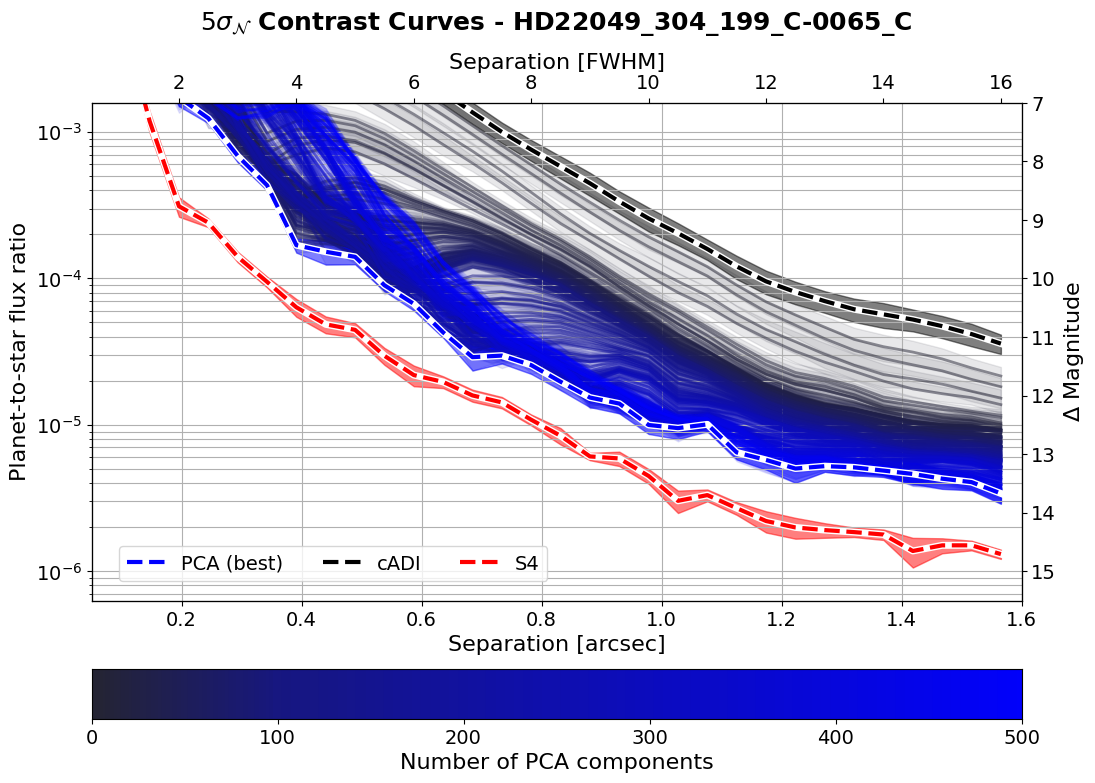

In [39]:
plot_old = False

# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
gs0 = fig.add_gridspec(2, 1, height_ratios=[1, 0.1], hspace=0.25)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])

# ------------------- Create the PCA number legend -----------
axis_legend_lines = fig.add_subplot(gs0[1, 0])

for idx, tmp_model in enumerate(pca_contrast_curves.columns):
    tmp_components = int(tmp_model[4:7])
    if tmp_components < 100:
        lw=3
    else:
        lw=8
    axis_legend_lines.vlines(
        [tmp_components], 
        ymin=0, ymax=1, color=colors[idx],
        lw=lw)
    
axis_legend_lines.set_xlim(0, 500)
axis_legend_lines.set_ylim(0, 1)
axis_legend_lines.set_yticks([])
axis_legend_lines.tick_params(
    axis='both', which='major', labelsize=14)

axis_legend_lines.set_xlabel("Number of PCA components", size=16)


# ---------------------- Create the PCA plots --------------------
i = 0 # color picker

for tmp_model in pca_contrast_curves.columns:

    tmp_flux_ratios = pca_contrast_curves.reset_index(
        level=0)[tmp_model].values
    tmp_errors = pca_contrast_errors.reset_index(
        level=0)[tmp_model].values

    axis_contrast_curvse.plot(
        separations_arcsec,
        tmp_flux_ratios,
        color = colors[i],
        lw=2,
        alpha=0.5)

    axis_contrast_curvse.fill_between(
        separations_arcsec,
        tmp_flux_ratios + tmp_errors,
        tmp_flux_ratios - tmp_errors,
        color = colors[i],
        alpha=0.1)
    i+=1

axis_contrast_curvse.set_yscale("log")

# ----------- Plot the best PCA contrast -------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    overall_best_pca,
    color = "white",
    lw=5)

axis_contrast_curvse.plot(
    separations_arcsec,
    overall_best_pca,
    color = "blue",
    lw=3,
    label="PCA (best)",
    ls="dashed")

axis_contrast_curvse.fill_between(
    separations_arcsec,
    overall_best_pca + best_contrast_errors_pca,
    overall_best_pca - best_contrast_errors_pca,
    color = "blue",
    alpha=0.5)

# ----------- Plot the raw contrast -------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    cADI_contrast_curve.values,
    color = "white",
    lw=5)

axis_contrast_curvse.plot(
    separations_arcsec,
    cADI_contrast_curve.values,
    color = "black",
    lw=3,
    label="cADI",
    ls="dashed")

axis_contrast_curvse.fill_between(
    separations_arcsec,
    cADI_contrast_curve.values + cADI_contrast_error.values,
    cADI_contrast_curve.values - cADI_contrast_error.values,
    color = "black",
    alpha=0.5)

# ----------- Plot the S4 contrast --------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    s4_contrast_curve.values,
    color = "white",
    lw=5)

axis_contrast_curvse.plot(
    separations_arcsec,
    s4_contrast_curve.values,
    color = "red",
    lw=3,
    label="S4",
    ls="dashed")

axis_contrast_curvse.fill_between(
    separations_arcsec,
    s4_contrast_curve.values + s4_contrast_error.values,
    s4_contrast_curve.values - s4_contrast_error.values,
    color = "red",
    alpha=0.5)

# ------------ Plot the overall best -------------------------
if plot_old:
    axis_contrast_curvse.plot(
        pca_sep,
        pca_contrast,
        color = "white",
        lw=6)

    axis_contrast_curvse.plot(
        pca_sep,
        pca_contrast,
        color = "green",
        lw=3,
        ls="dashed",
        label="Old best PCA")

# ------------- Double axis and limits -----------------------
lim_mag_y = (15.5, 7)
lim_arcsec_x = (0.05, 1.6)

sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec,
    separations_FWHM,
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    flux_ratio2mag(tmp_flux_ratios),
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    tmp_flux_ratios,
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]),
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [FWHM]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$5 \sigma_{\mathcal{N}}$ Contrast Curves - " + dataset_name[:-1],
    fontsize=18, fontweight="bold", y=1.13)

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

leg1 = fig.legend(handles, labels,
                  bbox_to_anchor=(0.14, 0.27),
                  fontsize=14,
                  #title="# PCA components",
                  loc='lower left', ncol=8)

_=plt.setp(leg1.get_title(),fontsize=14)
plt.savefig("PCA_vs_S4_" + dataset_name + ".pdf", bbox_inches='tight')

# Comparison relative

In [ ]:
improvement_s4 = s4_contrast_curve.values / overall_best_pca

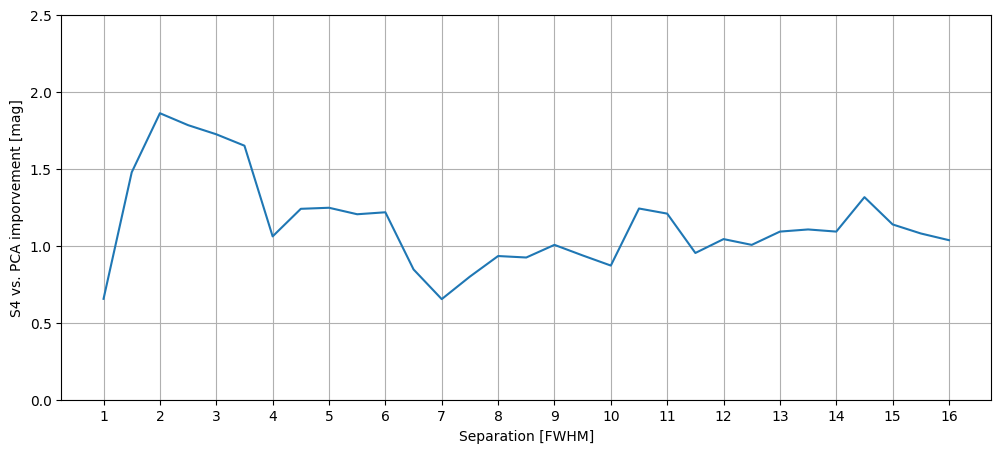

In [38]:
plt.figure(figsize=(12,5))

plt.plot(
    separations_FWHM,
    flux_ratio2mag(improvement_s4))
plt.grid()

_=plt.xticks(separations_FWHM.values[::2])
plt.xlabel("Separation [FWHM]")
plt.ylabel("S4 vs. PCA imporvement [mag]")
plt.ylim(0, 2.5)
plt.savefig("Relative_PCA_vs_S4_" + dataset_name + ".pdf", bbox_inches='tight')